## first try to play around with the google map api

## objectives : create a map api that can extract information for living (eg  restaurant nearby/cinema/safety) within certain parameters

### try to create a function that takes name/coordination and distances and visualize anything nearby
#### get the information of nearby location eg cinema,gym,restaurant ✓
#### visualize the data on map ✓
#### get safety indicator in the map ✓

##### create a references of the safety of the objective area againist the entire city to see  if it is relatively dangous. I can do that by filling the distances of each crime spot and the objectives. And also update the crime spot so that it only provide crime spot of the certain area

#### add multiple interested location

### keep the api key safe


## alternative objectives 
### try scarp  reviews  and use NLP to analysis the review of the building
### choose different ways to present safety? for example use formula to measure the color of the area?
### get the area indication by radius?( eg when i put the lat,lng and radius it will shows the area around the lat,lng) 

In [11]:
import pandas as pd
import time
import googlemaps
from datetime import datetime
import api_lib
import numpy as np

In [32]:
import os 
import folium
from folium import plugins
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es

import geopy.distance



In [35]:
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.geodesic(coords_1, coords_2).m)

279352.90160430095


In [50]:
def calculateDistance(x1,y1,x2,y2):
    coords_1,coords_2=(x1,y1),(x2,y2)    
    dist=geopy.distance.geodesic(coords_1, coords_2).km
    return dist

In [5]:
def miles_to_meters(miles):
    try:
        return miles * 1_609.344
    except:
        return 0

In [6]:
def get_lag_lng(address):
    API_KEY = api_lib.keys
    map_client = googlemaps.Client(API_KEY)

    address = address
    geocode = map_client.geocode(address=address)
    (lat, lng) = map(geocode[0]['geometry']['location'].get, ('lat', 'lng'))
    return lat,lng

In [7]:
def get_nearby_objectives(address,objectives,radius):
    API_KEY = api_lib.keys
    map_client = googlemaps.Client(API_KEY)

    address = address
    geocode = map_client.geocode(address=address)
    (lat, lng) = map(geocode[0]['geometry']['location'].get, ('lat', 'lng'))


    search_string = objectives
    distance = miles_to_meters(radius)
    business_list = []

    response = map_client.places_nearby(
    location=(lat, lng),
    keyword=search_string,
    radius=distance
    )   

    business_list.extend(response.get('results'))
    next_page_token = response.get('next_page_token')

    while next_page_token:
        time.sleep(2)
        response = map_client.places_nearby(
            location=(lat, lng),
            keyword=search_string,
            radius=distance,
            page_token=next_page_token
        )   
        business_list.extend(response.get('results'))
        next_page_token = response.get('next_page_token')

    df = pd.DataFrame(business_list)
    df['url'] = 'https://www.google.com/maps/place/?q=place_id:' + df['place_id']
    return df

In [8]:
def show_address_on_map(address,zoom=30):
    lat,lng=get_lag_lng(address)
    m = folium.Map(location=[lat,lng],zoom_start=zoom)
    folium.Marker(
        location=[lat, lng], # coordinates for the marker (Earth Lab at CU Boulder)
        popup='you are here', # pop-up label for the marker
        icon=folium.Icon()
    ).add_to(m)
    return m

In [59]:
def show_crime(address):
    incidents = folium.map.FeatureGroup()

    map_shef=show_address_on_map(address,zoom=50)
    df=pd.read_csv('data_references/2022-03-south-yorkshire-outcomes.csv')
    df.dropna(axis=0,inplace=True)
    lat,lng=get_lag_lng(address)
    df['distances']=np.vectorize(calculateDistance)(lng,lat,df.Longitude,df.Latitude)
    for lat, lng, in zip(df.Latitude,df.Longitude):
        incidents.add_child(
        folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
        ))

    return map_shef.add_child(incidents)

In [60]:
show_crime('west one plaza 2,sheffield,United Kingdom')

In [41]:
df=pd.read_csv('data_references/2022-03-south-yorkshire-outcomes.csv')

In [42]:
df.dropna(axis=0,inplace=True)

In [43]:
long,lat=get_lag_lng('west one plaza 2,sheffield,united Kingdom')

In [51]:
df['distances']=np.vectorize(calculateDistance)(long,lat,df.Longitude,df.Latitude)

In [54]:
import matplotlib.pyplot as plt

(array([3.000e+00, 1.253e+03, 4.520e+03, 6.583e+03, 2.680e+02, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([7840.66020377, 7860.20686592, 7879.75352808, 7899.30019023,
        7918.84685238, 7938.39351454, 7957.94017669, 7977.48683885,
        7997.033501  , 8016.58016316, 8036.12682531]),
 <BarContainer object of 10 artists>)

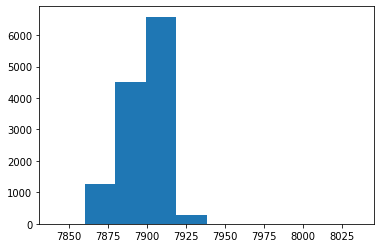

In [55]:
!git add Untitled.ipynb
!git commit -m 'seems the distances I get is not very good, and I hope I can solve it '